In [7]:
cd ../../content/drive/Shared\ drives/Kaggle_share/M5/notebook

/content/drive/Shared drives/Kaggle_share/M5/notebook


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import os
import lightgbm as lgb
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import json
import importlib

#predictのための読み込み関数
from pred_func import rolling_lag_Feature_shift1
from pred_func import rolling_lag_Feature_shift1
#from pred_func import wavelet_rolling_lag_Feature_shift1

In [0]:
class groupgby_dataset():
    def __init__(self,category = None,category_num = None,category_2nd = None,category_num_2nd = None):
        self.dir = '../features/'
        with open('../data/data_full.joblib', mode="rb") as f:
            self.data = joblib.load(f)
        self.idx = self.data[self.data[category] == category_num].index
        self.data = self.data.iloc[self.idx]
        
        if category_2nd != None:
            self.idx = self.data[self.data[category_2nd] == category_num_2nd].index
            self.data = self.data.iloc[self.idx]
        
        #weitht1, weight2, weight_mat_csr読み込み
        with open("../weight/weight1_" + category + "_"+ str(category_num) +".joblib", mode="rb") as f:
            self.weight1 = joblib.load(f)
        with open("../weight/weight2_" + category + "_"+ str(category_num) +".joblib", mode="rb") as f:
            self.weight2 = joblib.load(f)
        with open("../weight/weight_mat_csr_" + category + "_"+ str(category_num) +".joblib", mode="rb") as f:
            self.weight_mat_csr = joblib.load(f)
    
            
    def get_features(self,features = None ,path = None):

    #作成した特徴量の取得
        if features == None:
            print('features not selected')
            exit(0)
        else:
            dfs = []
            for feature in features:
                with open(path +'/'+ feature, mode="rb") as f:
                    tmp = joblib.load(f)
                    dfs.append(tmp.iloc[self.idx])
            tmp = pd.concat(dfs, axis=1)
            self.data = pd.concat([self.data,tmp],axis=1)

        return self.data
    
    def drop_features(self,features = None):
        self.data = self.data.drop(columns = features)
    
    def wrmsse(self,preds = None, data = None):
        NUM_ITEMS = 3049
        DAYS_PRED = 28
        # this function is calculate for last 28 days to consider the non-zero demand period

        # actual obserbed values / 正解ラベル
        y_true = data.get_label()

        y_true = y_true[-(NUM_ITEMS * DAYS_PRED):]
        preds = preds[-(NUM_ITEMS * DAYS_PRED):]
        # number of columns
        num_col = DAYS_PRED

        # reshape data to original array((NUM_ITEMS*num_col,1)->(NUM_ITEMS, num_col) ) / 推論の結果が 1 次元の配列になっているので直す
        reshaped_preds = np.array(preds).reshape(num_col, NUM_ITEMS).T
        reshaped_true = np.array(y_true).reshape(num_col, NUM_ITEMS).T


        train = self.weight_mat_csr*np.c_[reshaped_preds, reshaped_true]

        score = np.sum(
                    np.sqrt(
                        np.mean(
                            np.square(
                                train[:,:num_col] - train[:,num_col:])
                            ,axis=1) / self.weight1) * self.weight2)

        return 'wrmsse', score, False

In [0]:
class lightgbm():
    def __init__(self ,data):
        self.data = data
        
    def get_params(self,params):
        self.params = params
        
    def get_features(self , features):
        self.features = features
        
    def get_train_test(self):
        self.data_train = self.data[self.data['part'] == 'train']
        self.data_test = self.data[self.data['part'] == 'test1']
        del self.data
    
    
    def hold_out(self):
        END_TRAIN   = 1913               # End day of our train set
        P_HORIZON   = 28  
        self.get_train_test()
        x_val = self.data_train[self.data_train['d'] > (END_TRAIN-P_HORIZON)]
        y_val = self.data_train[self.data_train['d'] > (END_TRAIN-P_HORIZON)]['demand']
        x_train = self.data_train[self.data_train['d'] <= (END_TRAIN-P_HORIZON)] 
        y_train = self.data_train[self.data_train['d'] <= (END_TRAIN-P_HORIZON)]['demand']
        train_set = lgb.Dataset(x_train[self.features], y_train)
        val_set = lgb.Dataset(x_val[self.features], y_val)
        del x_val ,y_val ,x_train ,y_train
        return train_set , val_set
    
    
    
    def valid_fit(self,hold_out = None , model_name = 'sample', model_save = None ) :
        self.model_name = model_name
        if hold_out == True:
            
            train_set,val_set = self.hold_out()
            num_boost_round = 2500
            early_stopping_rounds = 1
            self.model = lgb.train(self.params, train_set, num_boost_round = num_boost_round, early_stopping_rounds = early_stopping_rounds, 
                  valid_sets = val_set, verbose_eval = 100, feval = data.wrmsse)
            
            if model_save == True:
              filename =  '../Model/'+model_name+ '.joblib'
              joblib.dump(self.model, filename)
            
            self.best_score_ = self.model.best_score
            
            
            ##feature_importance
            self.feature_importances_ = self.model.feature_importance()
                                      
            fi_df = pd.DataFrame({'feature': self.features,'feature importance': self.feature_importances_}).sort_values('feature importance', ascending = False)
            plt.figure(figsize=(10,10))
            sns.barplot(fi_df['feature importance'],fi_df['feature'])
            plt.rcParams["font.size"] = 15
            plt.savefig('../logs/' + model_name + '_fi.png')
            
            
            ##config
            dictionary = {'features':self.features, 'params':self.params, 'cv':'hold_out' ,
              'num_boost_round':num_boost_round ,'early_stopping_rounds':early_stopping_rounds , 'num_trees':self.model.num_trees()}
            with open('../config/' + model_name +'.json' , 'w') as outfile:
                json.dump(dictionary, outfile)
                
                
            ##score(適当)
            with open('../logs/' + model_name + '.log', mode='w') as f:
                f.write(str(self.model.best_score))

            del train_set , val_set

      #   if time_spilt == True:
       #     ##timesplitのホールドアウト
        #    return 0 


    def fit(self , valid_name =None,model_save = None):

      #jsonからvalidのパラメータ読み込み
      json_open = open('../config/' + valid_name +'.json', 'r')
      json_data = json.load(json_open)
      json_open.close()
      self.features = json_data['features']
      self.params = json_data['params']
      num_boost_round = json_data['num_trees']
      self.params['n_estimators'] = json_data['num_trees']

      #train_data作成、test1の正解追加後に変更必須
      data_train = self.data[self.data['part'] == 'train']
      train_set = lgb.Dataset(data_train[self.features], data_train['demand'])
      self.model = lgb.train(self.params, train_set, num_boost_round = num_boost_round)

      if model_save == True:
        filename =  '../Model/'+ valid_name + 'all_data' + '.joblib'
        joblib.dump(self.model, filename)
            


    
    def predict(self , rolling_lag_Feature_shift1_cols , Ordered_TS_mean_encoding_shift1_cols,data , part = 'test1'):
      
      self.data = data
      ##part(test1 or test2)の範囲の日付をとってくる
      predict_range = self.data[self.data['part'] == part]['d'].unique()

      for i in predict_range:
        print('predict_DAY : {0}'.format(i))

        #rolling_lag_Feature_shift1(更新の必要な特徴量)の更新
        rolling_lag_Feature_shift1.create_features( self.data , features = rolling_lag_Feature_shift1_cols )


        #Ordered_TS_mean_encoding_shift1(更新の必要な特徴量)の更新
        Ordered_TS_mean_encoding_shift1.create_features( self.data , features = Ordered_TS_mean_encoding_shift1_cols)

        #新しい特徴量を使った予測
        tmp = self.model.predict(self.data[self.data['d'] ==i][self.features])

        #ループの日付のdemand部分を置き換える
        self.data.loc[self.data[self.data['d'] ==i].index , 'demand'] = tmp

      filename = '../predict/' + self.model_name +'_' + part + '.joblib' 
      joblib.dump(self.data[self.data['part'] == 'test1']['demand'],filename)


    def load_model(self , model_name = None):
      self.model_name = model_name
      with open('../Model/' + model_name + '.joblib', mode="rb") as f:
          self.model = joblib.load(f)
                              
        
        

In [0]:
data = groupgby_dataset(category='store_id' , category_num= 1)

In [73]:
path = '../features/SNAP_Feature'
data.get_features(features=os.listdir(path) , path = path)

,id,item_id,dept_id,cat_id,store_id,state_id,day,demand,part,date,wm_yr_wk,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,Lag_SNAP_CA,Lag_SNAP_TX,Lag_SNAP_WI
837,HOBBIES_1_004_CA_2_validation,1440,3,1,1,0,d_1,6.0,train,2011-01-29,11101,1,30,4,4,2,0,0,0,4.339844,1,1,1
838,HOBBIES_1_009_CA_2_validation,1445,3,1,1,0,d_1,2.0,train,2011-01-29,11101,1,30,4,4,2,0,0,0,1.559570,1,1,1
839,HOBBIES_1_016_CA_2_validation,1452,3,1,1,0,d_1,23.0,train,2011-01-29,11101,1,30,4,4,2,0,0,0,0.700195,1,1,1
840,HOBBIES_1_020_CA_2_validation,1456,3,1,1,0,d_1,1.0,train,2011-01-29,11101,1,30,4,4,2,0,0,0,10.671875,1,1,1
841,HOBBIES_1_022_CA_2_validation,1458,3,1,1,0,d_1,1.0,train,2011-01-29,11101,1,30,4,4,2,0,0,0,6.859375,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47624219,FOODS_3_823_CA_2_validation,1432,2,0,1,0,d_1969,0.0,test2,2016-06-19,11621,1969,16,3,2,0,0,0,0,2.980469,9,4,4
47624220,FOODS_3_824_CA_2_validation,1433,2,0,1,0,d_1969,0.0,test2,2016-06-19,11621,1969,16,3,2,0,0,0,0,2.480469,9,4,4
47624221,FOODS_3_825_CA_2_validation,1434,2,0,1,0,d_1969,0.0,test2,2016-06-19,11621,1969,16,3,2,0,0,0,0,3.980469,9,4,4
47624222,FOODS_3_826_CA_2_validation,1435,2,0,1,0,d_1969,0.0,test2,2016-06-19,11621,1969,16,3,2,0,0,0,0,1.280273,9,4,4


In [74]:
path = '../features/rolling_lag_Feature_shift1'
data.get_features(features=os.listdir(path) , path = path)

,id,item_id,dept_id,cat_id,store_id,state_id,day,demand,part,date,wm_yr_wk,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,Lag_SNAP_CA,Lag_SNAP_TX,Lag_SNAP_WI,rolling_lag_sum_t84,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_lag_sum_t56,rolling_lag_std_t84,rolling_lag_std_t168,rolling_lag_sum_t7,rolling_lag_sum_t168,rolling_lag_sum_t28,rolling_lag_min_t56,rolling_lag_min_t168,rolling_lag_std_t7,rolling_lag_std_t56,rolling_lag_std_t28,rolling_lag_min_t84,rolling_lag_max_t7,rolling_lag_max_t56,rolling_lag_max_t168,rolling_lag_max_t84,rolling_lag_max_t28,rolling_lag_mean_t7,rolling_lag_median_t7,rolling_lag_mean_t168,rolling_lag_mean_t84,rolling_lag_mean_t56,rolling_lag_mean_t28,rolling_lag_median_t56,rolling_lag_median_t168,rolling_lag_median_t84,rolling_lag_median_t28,rolling_lag_min_t7,rolling_lag_min_t28
837,HOBBIES_1_004_CA_2_validation,1440,3,1,1,0,d_1,6.0,train,2011-01-29,11101,1,30,4,4,2,0,0,0,4.339844,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
838,HOBBIES_1_009_CA_2_validation,1445,3,1,1,0,d_1,2.0,train,2011-01-29,11101,1,30,4,4,2,0,0,0,1.559570,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
839,HOBBIES_1_016_CA_2_validation,1452,3,1,1,0,d_1,23.0,train,2011-01-29,11101,1,30,4,4,2,0,0,0,0.700195,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
840,HOBBIES_1_020_CA_2_validation,1456,3,1,1,0,d_1,1.0,train,2011-01-29,11101,1,30,4,4,2,0,0,0,10.671875,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
841,HOBBIES_1_022_CA_2_validation,1458,3,1,1,0,d_1,1.0,train,2011-01-29,11101,1,30,4,4,2,0,0,0,6.859375,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47624219,FOODS_3_823_CA_2_validation,1432,2,0,1,0,d_1969,0.0,test2,2016-06-19,11621,1969,16,3,2,0,0,0,0,2.980469,9,4,4,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.937988,1.582031,0.0,172.0,0.0,0.0,0.0,2.384186e-07,4.008789e-01,1.192093e-07,0.0,0.0,3.0,7.0,4.0,0.0,0.0,0.0,1.023438,0.345215,0.053558,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47624220,FOODS_3_824_CA_2_validation,1433,2,0,1,0,d_1969,0.0,test2,2016-06-19,11621,1969,16,3,2,0,0,0,0,2.480469,9,4,4,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.753418,0.550293,0.0,24.0,0.0,0.0,0.0,0.000000e+00,1.336670e-01,5.960464e-08,0.0,0.0,1.0,4.0,4.0,0.0,0.0,0.0,0.142822,0.285645,0.017853,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47624221,FOODS_3_825_CA_2_validation,1434,2,0,1,0,d_1969,0.0,test2,2016-06-19,11621,1969,16,3,2,0,0,0,0,3.980469,9,4,4,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.964844,0.751465,0.0,36.0,0.0,0.0,0.0,1.192093e-07,5.960464e-08,5.960464e-08,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.214233,0.357178,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47624222,FOODS_3_826_CA_2_validation,1435,2,0,1,0,d_1969,0.0,test2,2016-06-19,11621,1969,16,3,2,0,0,0,0,1.280273,9,4,4,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.788086,1.034180,0.0,108.0,0.0,0.0,0.0,0.000000e+00,4.008789e-01,5.960464e-08,0.0,0.0,3.0,7.0,4.0,0.0,0.0,0.0,0.643066,0.369141,0.053558,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
path = '../features/Ordered_TS_mean_encoding_shift1'
data.get_features(features=os.listdir(path) , path = path)

,id,item_id,dept_id,cat_id,store_id,state_id,day,demand,part,date,wm_yr_wk,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,Lag_SNAP_CA,Lag_SNAP_TX,Lag_SNAP_WI,rolling_lag_sum_t84,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_lag_sum_t56,rolling_lag_std_t84,rolling_lag_std_t168,rolling_lag_sum_t7,rolling_lag_sum_t168,rolling_lag_sum_t28,rolling_lag_min_t56,rolling_lag_min_t168,rolling_lag_std_t7,rolling_lag_std_t56,rolling_lag_std_t28,rolling_lag_min_t84,rolling_lag_max_t7,rolling_lag_max_t56,rolling_lag_max_t168,rolling_lag_max_t84,rolling_lag_max_t28,rolling_lag_mean_t7,rolling_lag_median_t7,rolling_lag_mean_t168,rolling_lag_mean_t84,rolling_lag_mean_t56,rolling_lag_mean_t28,rolling_lag_median_t56,rolling_lag_median_t168,rolling_lag_median_t84,rolling_lag_median_t28,rolling_lag_min_t7,rolling_lag_min_t28,Ordered_TS_id,Ordered_TS_store,Ordered_TS_cat,Ordered_TS_state,Ordered_TS_dept
837,HOBBIES_1_004_CA_2_validation,1440,3,1,1,0,d_1,6.0,train,2011-01-29,11101,1,30,4,4,2,0,0,0,4.339844,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.710938,5.179688,5.226562
838,HOBBIES_1_009_CA_2_validation,1445,3,1,1,0,d_1,2.0,train,2011-01-29,11101,1,30,4,4,2,0,0,0,1.559570,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.000000,4.722656,5.183594,5.234375
839,HOBBIES_1_016_CA_2_validation,1452,3,1,1,0,d_1,23.0,train,2011-01-29,11101,1,30,4,4,2,0,0,0,0.700195,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,4.699219,5.179688,5.203125
840,HOBBIES_1_020_CA_2_validation,1456,3,1,1,0,d_1,1.0,train,2011-01-29,11101,1,30,4,4,2,0,0,0,10.671875,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.335938,4.851562,5.199219,5.375000
841,HOBBIES_1_022_CA_2_validation,1458,3,1,1,0,d_1,1.0,train,2011-01-29,11101,1,30,4,4,2,0,0,0,6.859375,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.000000,4.820312,5.195312,5.332031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47624219,FOODS_3_823_CA_2_validation,1432,2,0,1,0,d_1969,0.0,test2,2016-06-19,11621,1969,16,3,2,0,0,0,0,2.980469,9,4,4,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.937988,1.582031,0.0,172.0,0.0,0.0,0.0,2.384186e-07,4.008789e-01,1.192093e-07,0.0,0.0,3.0,7.0,4.0,0.0,0.0,0.0,1.023438,0.345215,0.053558,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.765625,1.282227,2.035156,1.520508,2.533203
47624220,FOODS_3_824_CA_2_validation,1433,2,0,1,0,d_1969,0.0,test2,2016-06-19,11621,1969,16,3,2,0,0,0,0,2.480469,9,4,4,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.753418,0.550293,0.0,24.0,0.0,0.0,0.0,0.000000e+00,1.336670e-01,5.960464e-08,0.0,0.0,1.0,4.0,4.0,0.0,0.0,0.0,0.142822,0.285645,0.017853,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.457275,1.282227,2.035156,1.520508,2.533203
47624221,FOODS_3_825_CA_2_validation,1434,2,0,1,0,d_1969,0.0,test2,2016-06-19,11621,1969,16,3,2,0,0,0,0,3.980469,9,4,4,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.964844,0.751465,0.0,36.0,0.0,0.0,0.0,1.192093e-07,5.960464e-08,5.960464e-08,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.214233,0.357178,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.613770,1.282227,2.035156,1.520508,2.533203
47624222,FOODS_3_826_CA_2_validation,1435,2,0,1,0,d_1969,0.0,test2,2016-06-19,11621,1969,16,3,2,0,0,0,0,1.280273,9,4,4,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.788086,1.034180,0.0,108.0,0.0,0.0,0.0,0.000000e+00

In [77]:
path = '../features/price_feature'
data.get_features(features=os.listdir(path) , path = path)

,id,item_id,dept_id,cat_id,store_id,state_id,day,demand,part,date,wm_yr_wk,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,Lag_SNAP_CA,Lag_SNAP_TX,Lag_SNAP_WI,rolling_lag_sum_t84,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_lag_sum_t56,rolling_lag_std_t84,rolling_lag_std_t168,rolling_lag_sum_t7,rolling_lag_sum_t168,rolling_lag_sum_t28,rolling_lag_min_t56,rolling_lag_min_t168,rolling_lag_std_t7,...,rolling_lag_median_t168,rolling_lag_median_t84,rolling_lag_median_t28,rolling_lag_min_t7,rolling_lag_min_t28,Ordered_TS_id,Ordered_TS_store,Ordered_TS_cat,Ordered_TS_state,Ordered_TS_dept,rolling_price_mean_t7,rolling_price_mean_t28,rolling_price_mean_t56,rolling_price_mean_t84,rolling_price_mean_t168,rolling_price_std_t7,rolling_price_std_t28,rolling_price_std_t56,rolling_price_std_t84,rolling_price_std_t168,rolling_price_max_t7,rolling_price_max_t28,rolling_price_max_t56,rolling_price_max_t84,rolling_price_max_t168,rolling_price_min_t7,rolling_price_min_t28,rolling_price_min_t56,rolling_price_min_t84,rolling_price_min_t168,price_max,price_min,price_std,price_mean,price_norm,price_nunique,item_nunique,price_momentum,price_momentum_m,price_momentum_y
837,HOBBIES_1_004_CA_2_validation,1440,3,1,1,0,d_1,6.0,train,2011-01-29,11101,1,30,4,4,2,0,0,0,4.339844,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.710938,5.179688,5.226562,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.640625,4.339844,0.146362,4.523438,0.935059,2.0,2,NaN,0.959473,1.000000
838,HOBBIES_1_009_CA_2_validation,1445,3,1,1,0,d_1,2.0,train,2011-01-29,11101,1,30,4,4,2,0,0,0,1.559570,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,6.000000,4.722656,5.183594,5.234375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.769531,1.559570,0.032715,1.764648,0.881348,2.0,9,NaN,0.885742,0.896484
839,HOBBIES_1_016_CA_2_validation,1452,3,1,1,0,d_1,23.0,train,2011-01-29,11101,1,30,4,4,2,0,0,0,0.700195,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,4.699219,5.179688,5.203125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.720215,0.680176,0.011299,0.706543,0.972168,3.0,16,NaN,0.990234,1.001953
840,HOBBIES_1_020_CA_2_validation,1456,3,1,1,0,d_1,1.0,train,2011-01-29,11101,1,30,4,4,2,0,0,0,10.671875,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,10.335938,4.851562,5.199219,5.375000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.679688,10.671875,0.750488,12.156250,0.841797,4.0,3,NaN,0.867676,0.974121
841,HOBBIES_1_022_CA_2_validation,1458,3,1,1,0,d_1,1.0,train,2011-01-29,11101,1,30,4,4,2,0,0,0,6.859375,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,8.000000,4.820312,5.195312,5.332031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.179688,6.859375,0.083435,7.140625,0.955566,3.0,8,NaN,0.958496,0.984863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47624219,FOODS_3_823_CA_2_validation,1432,2,0,1,0,d_1969,0.0,test2,2016-06-19,11621,1969,16,3,2,0,0,0,0,2.980469,9,4,4,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.937988,1.582031,0.0,172.0,0.0,0.0,0.0,2.384186e-07,...,0.0,0.0,0.0,0.0,0.0,1.765625,1.282227,2.035156,1.520508,2.533203,2.980469,2.980469,2.980469,2.980469,2.917969,0.0,5.960464e-08,0.0,5.960464e-08,0.124329,2.980469,2.980469,2.980469,2.980469,2.980469,2.980469,2.980469,2.980469,2.980469,2.500000,2.980469,2.480469,0.155029,2.81

In [78]:
path = '../features/calendar_feature'
data.get_features(features=os.listdir(path) , path = path)

,id,item_id,dept_id,cat_id,store_id,state_id,day,demand,part,date,wm_yr_wk,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,Lag_SNAP_CA,Lag_SNAP_TX,Lag_SNAP_WI,rolling_lag_sum_t84,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_lag_sum_t56,rolling_lag_std_t84,rolling_lag_std_t168,rolling_lag_sum_t7,rolling_lag_sum_t168,rolling_lag_sum_t28,rolling_lag_min_t56,rolling_lag_min_t168,rolling_lag_std_t7,...,rolling_price_mean_t56,rolling_price_mean_t84,rolling_price_mean_t168,rolling_price_std_t7,rolling_price_std_t28,rolling_price_std_t56,rolling_price_std_t84,rolling_price_std_t168,rolling_price_max_t7,rolling_price_max_t28,rolling_price_max_t56,rolling_price_max_t84,rolling_price_max_t168,rolling_price_min_t7,rolling_price_min_t28,rolling_price_min_t56,rolling_price_min_t84,rolling_price_min_t168,price_max,price_min,price_std,price_mean,price_norm,price_nunique,item_nunique,price_momentum,price_momentum_m,price_momentum_y,year,quarter,month,week,dayofweek,is_year_end,is_year_start,is_quarter_end,is_quarter_start,is_month_end,is_month_start,day2
837,HOBBIES_1_004_CA_2_validation,1440,3,1,1,0,d_1,6.0,train,2011-01-29,11101,1,30,4,4,2,0,0,0,4.339844,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.640625,4.339844,0.146362,4.523438,0.935059,2.0,2,NaN,0.959473,1.000000,2011,1,1,4,5,0,0,0,0,0,0,29
838,HOBBIES_1_009_CA_2_validation,1445,3,1,1,0,d_1,2.0,train,2011-01-29,11101,1,30,4,4,2,0,0,0,1.559570,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.769531,1.559570,0.032715,1.764648,0.881348,2.0,9,NaN,0.885742,0.896484,2011,1,1,4,5,0,0,0,0,0,0,29
839,HOBBIES_1_016_CA_2_validation,1452,3,1,1,0,d_1,23.0,train,2011-01-29,11101,1,30,4,4,2,0,0,0,0.700195,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.720215,0.680176,0.011299,0.706543,0.972168,3.0,16,NaN,0.990234,1.001953,2011,1,1,4,5,0,0,0,0,0,0,29
840,HOBBIES_1_020_CA_2_validation,1456,3,1,1,0,d_1,1.0,train,2011-01-29,11101,1,30,4,4,2,0,0,0,10.671875,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.679688,10.671875,0.750488,12.156250,0.841797,4.0,3,NaN,0.867676,0.974121,2011,1,1,4,5,0,0,0,0,0,0,29
841,HOBBIES_1_022_CA_2_validation,1458,3,1,1,0,d_1,1.0,train,2011-01-29,11101,1,30,4,4,2,0,0,0,6.859375,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.179688,6.859375,0.083435,7.140625,0.955566,3.0,8,NaN,0.958496,0.984863,2011,1,1,4,5,0,0,0,0,0,0,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47624219,FOODS_3_823_CA_2_validation,1432,2,0,1,0,d_1969,0.0,test2,2016-06-19,11621,1969,16,3,2,0,0,0,0,2.980469,9,4,4,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.937988,1.582031,0.0,172.0,0.0,0.0,0.0,2.384186e-07,...,2.980469,2.980469,2.917969,0.0,5.960464e-08,0.0,5.960464e-08,0.124329,2.980469,2.980469,2.980469,2.980469,2.980469,2.980469,2.980469,2.980469,2.980469,2.500000,2.980469,2.480469,0.155029,2.818359,1.000000,5.0,205,1.0,1.033203,1.023438,2016,2,6,24,6,0,0,0,0,0,0,19
47624220,FOODS_3_824_CA_2_validation,1433,2,0,1,0,d_1969,0.0,test2,2016-06-19,11621,1969,16,3,2,0,0,0,0,2.480469,9,4,4,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.753418,0.550293,0.0,24.0,0.0,0.0,0.0,0.000000e+00,...,2.480469,2.480469,2.578125,0.0,0.000000e+00,0.0,0.000000e+00,0.099854,2.480469,2.480469,2.480469,2.480

In [0]:
########################### Model params
lgb_params = {
                    'boosting_type': 'gbdt',
                    'objective': 'tweedie',
                    'tweedie_variance_power': 1.1,
                    'metric': 'custom',
                    'subsample': 0.5,
                    'subsample_freq': 1,
                    'learning_rate': 0.03,
                    'num_leaves': 2**11-1,
                    'min_data_in_leaf': 2**12-1,
                    'feature_fraction': 0.5,
                    'max_bin': 100,
                    'n_estimators': 1400,
                    'boost_from_average': False,
                    'verbose': -1,
                } 

In [0]:
########################### features

base_features = [ "item_id","dept_id","cat_id","event_name_1","event_type_1","event_name_2","event_type_2", "snap_CA","sell_price"]

demand_lag_features_shift1 = ['rolling_lag_std_t28','rolling_lag_mean_t7', 'rolling_lag_mean_t28', 'rolling_lag_sum_t28',
 'rolling_lag_max_t28', 'rolling_lag_mean_t84', 'rolling_lag_std_t7',  'rolling_lag_sum_t84', 'rolling_lag_std_t84','rolling_lag_mean_t168', 'rolling_lag_std_t56', 'rolling_lag_mean_t56', 
 'rolling_lag_min_t28', 'rolling_lag_std_t168','rolling_lag_sum_t168' ,'lag_1']

SNAP_lag_features = ['Lag_SNAP_CA']

Ordered_TS_features = ['Ordered_TS_id' , 'Ordered_TS_cat' , 'Ordered_TS_dept']

price_feature = ['rolling_price_mean_t7'	,'rolling_price_mean_t28'	,'rolling_price_mean_t56',	'rolling_price_mean_t84'	,'rolling_price_mean_t168'	,
                 'rolling_price_std_t7'	,'rolling_price_std_t28'	,'rolling_price_std_t56'	,'rolling_price_std_t84'	,'rolling_price_std_t168'	,
                 'price_max' ,'price_min' ,'price_std' ,'price_mean' ,'price_norm' ,'price_nunique' ,'item_nunique','price_momentum','price_momentum_m','price_momentum_y']

calendar_feature = ['day2','week' , 'month', 'year' , 'quarter' , 'dayofweek' , 'is_month_end' , 'is_month_start'  , 'is_quarter_end' , 'is_quarter_start' , 'is_year_end' , 'is_year_start' ]

features = base_features  +demand_lag_features_shift1 + SNAP_lag_features + calendar_feature + price_feature + Ordered_TS_features

In [0]:
###features(相関の高い特徴量を消す)

counter = 0
to_remove = []
for feat_a in features:
    for feat_b in features:
        if feat_a != feat_b and feat_a not in to_remove and feat_b not in to_remove:
            c = np.corrcoef(data.data[feat_a], data.data[feat_b])[0][1]
            if c > 0.995:
                counter += 1
                to_remove.append(feat_b)
                print('{}: FEAT_A: {} FEAT_B: {} - Correlation: {}'.format(counter, feat_a, feat_b, c))

In [0]:
lgb_clf = lightgbm(data = data.data)
#del data

In [0]:
lgb_clf.get_params(params=lgb_params)
lgb_clf.get_features(features=features)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 1 rounds.
[100]	valid_0's wrmsse: 0.647931
Early stopping, best iteration is:
[124]	valid_0's wrmsse: 0.589575


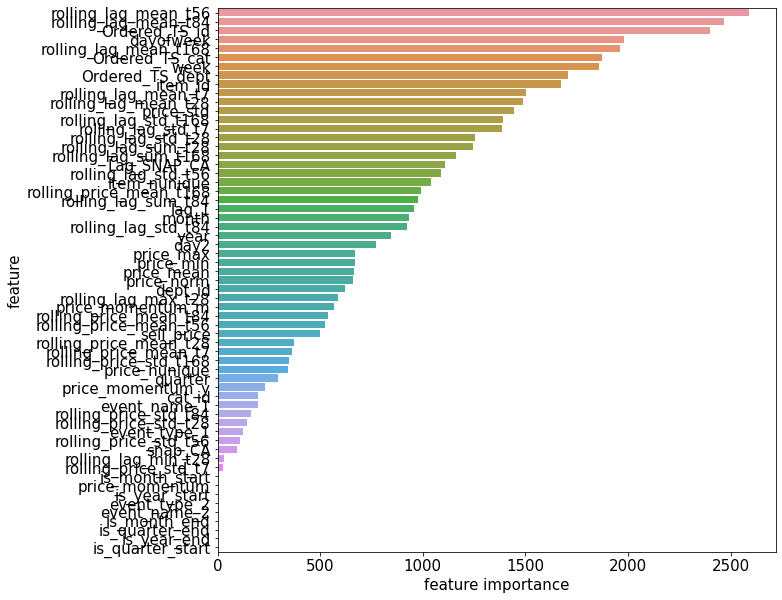

In [131]:
lgb_clf.valid_fit(model_name = 'sample' ,model_save=False , hold_out = True)

In [0]:
lgb_clf.predict(rolling_lag_Feature_shift1_cols = demand_lag_features_shift1 , data = data.data)

In [0]:
lgb_clf.load_model(model_name= 'store1_0516_oshima')

In [149]:
lgb_clf = lightgbm(data.data)
lgb_clf.fit(valid_name='sample' , model_save=False)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [150]:
lgb_clf.model.num_trees()

124